In [1]:
%pip install scikit-learn 

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-learn in c:\users\ezzel\appdata\local\programs\python\python311\lib\site-packages (1.6.0)




[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import math
from scipy.fftpack import fft2, fftshift
from collections import Counter
from scipy.signal import find_peaks



def crop_image_contour_sorry_kiwi(img_gray): 
    if img_gray.dtype != np.uint8:
        img_gray = cv2.convertScaleAbs(img_gray)

    # Apply binary thresholding
    _, binary_img = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)

    # Apply morphological closing to merge nearby bars
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))  # Adjust kernel size if needed
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(closed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Identify the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the bounding box
    x, y, w, h = cv2.boundingRect(largest_contour)
    contour_img = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)  # Convert to color for visualization
    cv2.rectangle(contour_img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Adjust the bounding box to shift left and right
    shifted_x = x - 1  # Shift left by 1 pixel
    shifted_w = w + 1  # Increase width by 1 pixel to compensate

    # Ensure the coordinates don't go out of bounds (optional)
    shifted_x = max(0, shifted_x)  # Ensure x doesn't go below 0
    shifted_w = min(img_gray.shape[1] - shifted_x, shifted_w)  # Ensure the width doesn't exceed the image width

    # Crop the image with the adjusted bounding box
    cropped_barcode = img_gray[y:y+h, shifted_x:shifted_x+shifted_w]
    # Display the original image and cropped barcode
    # plt.imshow(cropped_barcode, cmap='gray')
    # plt.title("Cropped Barcode"), plt.axis('off')

    bottom_pixels=10
    top_pixels=10

    # Calculate new dimensions
    height, width = cropped_barcode.shape[:2]
    cropped_image = cropped_barcode[top_pixels:height-bottom_pixels, :]
    
    return cropped_image

  
def threshold_image(image,threshold_value,max_value):
    #every pixel that has value greater than or equal threshold_value, will be set to max_value, otherwise the pixel will be zero (black)
    _, thresholded_image = cv2.threshold(image, threshold_value, max_value, cv2.THRESH_BINARY)
    return thresholded_image

def sobel_edge_detection(image):
    # Add 3 pixels of white padding around the image
    padded_image = cv2.copyMakeBorder(image, 3, 3, 3, 3, cv2.BORDER_CONSTANT, value=255)
    
    # Perform Sobel edge detection on the padded image
    sobel_x = cv2.Sobel(padded_image, cv2.CV_64F, 1, 0, ksize=3)  
    sobel_y = cv2.Sobel(padded_image, cv2.CV_64F, 0, 1, ksize=3) 
    edges = cv2.magnitude(sobel_x, sobel_y)
    edges = cv2.convertScaleAbs(edges)
    
    # Remove the padding from the edge-detected image
    final_edges = edges[3:-3, 3:-3]
    
    return final_edges


def display_image(img,title=''):
        plt.figure(figsize=(8, 6))  
        plt.imshow(img,cmap='gray')
        plt.axis('off') 
        plt.title(title)
        plt.show()


def show_frequency_domain(image,title=''):
    # Perform Fourier Transform
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # Shift zero frequency component to the center
    # Compute magnitude spectrum
    magnitude = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
    magnitude_spectrum = 20 * np.log1p(magnitude)  # Log scale for better visibility

    # Display the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1), plt.imshow(image, cmap='gray')
    plt.title('Original Image'), plt.axis('off')
    plt.subplot(1, 2, 2), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Frequency Domain'+title), plt.axis('off')
    plt.show()


def find_threshold_value(img_gray):
    
    hist_counts, bin_edges = np.histogram(img_gray.ravel(), bins=64, range=(0, 256))
    
    # Total number of pixels in the image
    total_pixels = img_gray.size
    
    # Calculate the number of pixels in the dark region (0 to 127)
    dark_pixels = np.sum(hist_counts[:32])  # The first 32 bins correspond to pixel values from 0 to 127

    # Calculate the number of pixels in the bright region (128 to 255)
    bright_pixels = np.sum(hist_counts[32:])  # The remaining 32 bins correspond to pixel values from 128 to 255

    # Calculate the percentage of dark and bright pixels
    dark_percentage = dark_pixels / total_pixels
    bright_percentage = bright_pixels / total_pixels

    # Get indices of the top 5 bins with the highest counts, excluding zero bins
    non_zero_indices = np.where(hist_counts > 0)[0] 
    top_5_indices = np.argsort(hist_counts[non_zero_indices])[-5:][::-1]  
    top_5_bins = [bin_edges[non_zero_indices[i]] for i in top_5_indices]

    # print(f"Top 5 bins: {top_5_bins}")

    # Calculate the simple average of the top 5 bins

    # Tried weighted average first but this is better apparently and kinda makes sense
    top_5_values = [np.mean([bin_edges[non_zero_indices[i]], bin_edges[non_zero_indices[i] + 1]]) for i in top_5_indices]

    # Compute the simple average of the top 5 bins
    average = np.mean(top_5_values)
    # print(f"Average of the top 5 bins: {average}")

    # Check if bins are concentrated near 128 (contrast issues)
    contrast_bin_range = (120, 136)  # Define a range around 128
    contrast_bins = np.sum(hist_counts[np.logical_and(bin_edges[:-1] >= contrast_bin_range[0], bin_edges[:-1] < contrast_bin_range[1])])
    contrast_percentage = contrast_bins / total_pixels

    if contrast_percentage > 0.6:  # Threshold for contrast concentration
        # print("The image likely has contrast issues with pixel values concentrated around 128.")
        return math.floor(average)

    if dark_percentage > 0.8:
        #  print("The image is biased towards dark (0) regions.")
         return math.floor(average)  # Return the threshold for dark-biased images
    elif bright_percentage > 0.95:
        #  print("The image is biased towards bright (255) regions.")
         return math.floor(average)  # Return the threshold for bright-biased images
    else:
        # Optionally, you can return the average in other cases
        #  print("The image has a balanced distribution of dark and bright regions.")
         return math.floor(average)

    



def create_smooth_mask(rows, cols, crow, ccol, bandwidth, horizontal, vertical):
    mask = np.zeros((rows, cols, 2), np.float32)
    for i in range(rows):
        for j in range(cols):
            # Gaussian falloff for the horizontal band
            if horizontal and abs(i - crow) < bandwidth:
                mask[i, j, :] = np.exp(-((i - crow) ** 2) / (2 * bandwidth ** 2))
            # Gaussian falloff for the vertical band
            if vertical and abs(j - ccol) < bandwidth:
                mask[i, j, :] = np.exp(-((j - ccol) ** 2) / (2 * bandwidth ** 2))
    return mask



def mask_freq(image,horizontal,vertical):
    # Perform Fourier Transform to convert the image to frequency domain
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # Shift zero frequency to the center

    # Get the magnitude spectrum for visualization
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

    # Create a mask to retain horizontal and vertical frequencies
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Center of the frequency domain



    bandwidth = 1  # Adjust this based on desired frequency range
    mask = create_smooth_mask(rows, cols, crow, ccol, bandwidth, horizontal, vertical)

    # Apply the mask to the frequency domain
    filtered_dft = dft_shift * mask

    # Shift back and inverse Fourier Transform to return to the spatial domain
    filtered_dft_shift = np.fft.ifftshift(filtered_dft)
    filtered_image = cv2.idft(filtered_dft_shift)
    filtered_image = cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

    # Normalize the filtered image for better visualization
    filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX)

    filtered_image=threshold_image(filtered_image,100,255)
    
    return filtered_image



def houghTransform(image):
    edge_detection=sobel_edge_detection(image)

    lines = cv2.HoughLinesP(edge_detection, 1, np.pi / 180, threshold=80, minLineLength=30, maxLineGap=200)

    # Create a copy of the thresholded_edges image to draw the lines
    final_image = edge_detection.copy()

    # Draw the lines on the thresholded_edges image with thinner lines
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Calculate the angle of the line
            angle = np.arctan2(y2 - y1, x2 - x1)
            # Exclude horizontal lines by checking if the angle is near 0 or π
            if abs(angle) > np.pi / 6:  # Threshold to avoid nearly horizontal lines (e.g., 10 degrees)
                cv2.line(final_image, (x1, y1), (x2, y2), (255), 1)  # Draw with thinner lines (thickness=1)



    contours, _ = cv2.findContours(final_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_image = np.zeros_like(final_image)

    # Fill the contours (regions inside the bars) with white
    cv2.drawContours(filled_image, contours, -1, (255), thickness=cv2.FILLED)
    cv2.drawContours(filled_image, contours, -1, (0), thickness=1) #remove contour



    # Invert the image
    inverted_image = cv2.bitwise_not(filled_image)

    inverted_image=crop_image_contour_sorry_kiwi(inverted_image)
    return inverted_image




def is_horizontal_sinc(image):
     # Step 1: Compute the 2D FFT of the image
    frequency_domain = fftshift(fft2(image))
    
    # Step 2: Get the magnitude spectrum
    magnitude_spectrum = np.abs(frequency_domain)
    
    # Step 3: Find the center of the spectrum
    center_y, center_x = magnitude_spectrum.shape[0] // 2, magnitude_spectrum.shape[1] // 2
    
    # Step 4: Analyze the spectrum
    # Horizontal sinc means energy should be concentrated along the center row (y=center_y)
    row_energy = magnitude_spectrum[center_y, :]
    col_energy = magnitude_spectrum[:, center_x]
    
    # A horizontal sinc would have significant energy in the center row and less in the center column
    row_energy_sum = np.sum(row_energy)
    col_energy_sum = np.sum(col_energy)
    
    # We consider it horizontal sinc if the row energy is significantly higher than column energy
    if row_energy_sum > col_energy_sum * 10:  # Adjust the threshold as needed
        # Ensure no other significant peaks in the spectrum
        other_energy = np.sum(magnitude_spectrum) - row_energy_sum
        if other_energy < row_energy_sum * 0.1:  # Allow some tolerance for noise
            return True
    
    return False







def rotate_img(img,angle):

    center = (img.shape[1] // 2, img.shape[0] // 2)

    rot_matrix = cv2.getRotationMatrix2D(center,-(180-angle) , 1.0)

    rotated_img = cv2.warpAffine(img, rot_matrix, (img.shape[1], img.shape[0]))

    return rotated_img


def find_angle(img_gray):

    if img_gray.dtype != np.uint8:
        img_gray = cv2.convertScaleAbs(img_gray)
    
    edges = cv2.Canny(img_gray, 50, 150, apertureSize=3)

    
    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

    angles = []

    if lines is not None:
        for rho, theta in lines[:, 0]:
            angle = np.degrees(theta)  
            angles.append(angle)  
           # print(f"Detected angle: {angle}")
    if angles:
        
        angle_counts = Counter(angles)
        
        
        top_5_angles = angle_counts.most_common(10)
        
        
        # print("\nTop 10 most repeated angles:")
        # for angle, count in top_5_angles:
    
        #     print(f"Angle: {angle:.2f} degrees, Count: {count}")

    if top_5_angles[0][0] == 45.00:
        return top_5_angles[1][0]  # Return the second most common angle
    else:
        return top_5_angles[0][0]  # Return the most common angle
    

    





def check_disconnected_vertical_lines(image):   
    # Detect vertical lines by summing pixel values along rows (columns)
    vertical_projection = np.sum(image, axis=0)
    
    # Check for disconnected vertical lines (gaps in the projection)
    disconnected_vertically = np.any(vertical_projection == 0)
    
    # Return True if disconnected vertical lines exist
    return disconnected_vertically




def detect_salt_pepper_noise(image, high_freq_threshold=0.5, energy_ratio_threshold=0.05):
    # Compute the 2D Fourier Transform and shift the zero-frequency component to the center
    f_transform = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_shifted)
    
    # Define high-frequency region
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    radius = int(min(rows, cols) * high_freq_threshold)
    
    # Create a mask for high frequencies
    y, x = np.ogrid[:rows, :cols]
    high_freq_mask = ((x - ccol)**2 + (y - crow)**2) > radius**2
    
    # Calculate energy ratio
    total_energy = np.sum(magnitude_spectrum**2)
    high_freq_energy = np.sum(magnitude_spectrum[high_freq_mask]**2)
    energy_ratio = high_freq_energy / total_energy if total_energy > 0 else 0
    
    # Return if the noise level exceeds the threshold
    return energy_ratio > energy_ratio_threshold


def fill_corners(rotated_img):
    # Make a copy to modify
    filled_image = rotated_img.copy()

    # Define flood fill parameters
    h, w = filled_image.shape
    flood_fill_color = 255  

    # Create a mask for flood fill (2 pixels larger than the image)
    mask = np.zeros((h + 2, w + 2), np.uint8)

   
    cv2.floodFill(filled_image, mask, seedPoint=(0, 0), newVal=flood_fill_color)  # Top-left corner
    cv2.floodFill(filled_image, mask, seedPoint=(w - 1, 0), newVal=flood_fill_color)  # Top-right corner
    cv2.floodFill(filled_image, mask, seedPoint=(0, h - 1), newVal=flood_fill_color)  # Bottom-left corner
    cv2.floodFill(filled_image, mask, seedPoint=(w - 1, h - 1), newVal=flood_fill_color)  # Bottom-right corner

    

    return filled_image

def perform_closing(binary_img, kernel_width=4, kernel_height=180):
    # Create a rectangular structuring element with a width of 4 pixels and height large enough to fill the gap
    kernel = np.ones((kernel_height, kernel_width), np.uint8)  # Vertical kernel to connect larger gaps
    
    # Perform closing operation (dilation followed by erosion)
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
    
    return closed_img




def remove_periodic_noise(image):
    # Step 1: Apply Fourier Transform to get frequency domain
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # Shift zero frequency to center
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

    # Step 2: Create a selective mask to suppress specific noise frequencies
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Center of the spectrum

    # Design a mask
    mask = np.ones((rows, cols, 2), np.uint8)

    # Suppress periodic noise by zeroing specific regions in the frequency domain
    for i in range(-10, 10, 20):  # Adjust this based on noise periodicity
        cv2.circle(mask, (ccol + i, crow), 5, (0, 0, 0), -1)
        cv2.circle(mask, (ccol, crow + i), 5, (0, 0, 0), -1)

    # Apply the mask
    fshift = dft_shift * mask

    # Step 3: Apply Inverse Fourier Transform
    f_ishift = np.fft.ifftshift(fshift)  # Shift back
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

    # Normalize the result
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
    img_back = img_back.astype(np.uint8)

    # Optional: Invert the image to make the barcode black on a white background
    # inverted_image = cv2.bitwise_not(img_back)

    return img_back









def connect_vertical_bars(binary_img, kernel_height=180):

    _,inverted_img = cv2.threshold(binary_img,128,255,cv2.THRESH_BINARY_INV)


    # Create a vertical kernel
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_height))

    # Apply morphological closing to connect vertical bars
    connected_img = cv2.morphologyEx(inverted_img, cv2.MORPH_CLOSE, vertical_kernel)

    connected_img=cv2.bitwise_not(connected_img)
    return connected_img



image=cv2.imread('11 - bayza 5ales di bsara7a.jpg', cv2.IMREAD_GRAYSCALE) 


def decode_barcode(pic):
    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    # Get the average of each column in the image
    mean = pic.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    
    while pixels and pixels[0] == '0':
        pixels = pixels[1:]

    print(pixels)

    # Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

    wide_bar_size = narrow_bar_size * 2

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    tolerance = 1  # Allow for tolerance of +1 and -1 on the narrow bar size

    while pixel_index < len(pixels):
        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1

        # Check if the count matches narrow or wide bar size with a tolerance of +1 or -1
        if (count == narrow_bar_size) or (count == narrow_bar_size + tolerance) or (count == narrow_bar_size - tolerance):
            current_digit_widths += NARROW
        elif (count == wide_bar_size) or (count == wide_bar_size + tolerance) or (count == wide_bar_size - tolerance):
            current_digit_widths += WIDE

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

    # Check if digits were decoded and print the barcode value
    if digits:
        
        print(f"Decoded barcode value: {digits}")
        return True
    else:
        print("Failed to decode the barcode.")
        return False






def perform_opening(binary_img, kernel_height=180, kernel_width=1):
    # Create a kernel with the specified height and width
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width, kernel_height))
    
    # Apply morphological opening
    opened_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
    
    return opened_img





def compute_histogram(img_gray, bins=64):
    # Compute histogram and bin edges
    hist_counts, bin_edges = np.histogram(img_gray.ravel(), bins=bins, range=(0, 256))
    total_pixels = img_gray.size
    return hist_counts, bin_edges, total_pixels

def detect_dark(hist_counts, bin_edges, total_pixels, threshold=0.8):
    # Calculate the number of dark pixels (0 to 127)
    dark_pixels = np.sum(hist_counts[:32])  # The first 32 bins correspond to pixel values from 0 to 127
    dark_percentage = dark_pixels / total_pixels
    
    if dark_percentage > threshold:
        print("The image is biased towards dark (0) regions.")
        return True
    return False 

def detect_bright(hist_counts, bin_edges, total_pixels, threshold=0.95):
    # Calculate the number of bright pixels (128 to 255)
    bright_pixels = np.sum(hist_counts[32:])  # The remaining 32 bins correspond to pixel values from 128 to 255
    bright_percentage = bright_pixels / total_pixels
    
    if bright_percentage > threshold:
        print("The image is biased towards bright (255) regions.")
        return True
    return False

def detect_contrast(hist_counts, bin_edges, total_pixels, contrast_range=(120, 160), threshold=0.4):
    # Check if bins are concentrated near 128 (contrast issues)
    contrast_bins = np.sum(hist_counts[np.logical_and(bin_edges[:-1] >= contrast_range[0], bin_edges[:-1] < contrast_range[1])])
    contrast_percentage = contrast_bins / total_pixels
    
    if contrast_percentage > threshold:
        print("The image likely has contrast issues with pixel values concentrated around 128.")
        return True
    return False

def variance_of_laplacian(image):
	# compute the Laplacian of the image and then return the focus
	# measure, which is simply the variance of the Laplacian
	return cv2.Laplacian(image, cv2.CV_64F).var()


def detectBlur(image):
    var=variance_of_laplacian(image)

    if var<2500:
        return True
    else :
        return False
    


def detect_periodic_noise_lines_with_opencv(image, offset=2, peak_threshold=0.1, min_peak_distance=10):
    """
    Detects periodic noise by analyzing specific rows in the frequency domain for sinc-like lines, using OpenCV for FFT.
    
    Parameters:
        image (numpy.ndarray): Input grayscale image.
        offset (int): Offset from the center row to analyze for periodic noise.
        peak_threshold (float): Minimum relative height of peaks to consider them significant.
        min_peak_distance (int): Minimum distance between peaks in the frequency domain.
    
    Returns:
        bool: True if periodic noise lines are detected, False otherwise.
        int: Number of periodic noise peaks detected.
    """
    # Step 1: Compute the 2D FFT of the image using OpenCV
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)  # Shift the zero frequency component to the center
    
    # Step 2: Compute the magnitude spectrum
    magnitude_spectrum = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
    
    # Step 3: Normalize the magnitude spectrum
    magnitude_spectrum /= np.max(magnitude_spectrum)
    
    # Step 4: Analyze rows above and below the center row
    center_y = magnitude_spectrum.shape[0] // 2
    rows_to_check = [center_y - offset, center_y + offset]
    
    total_peaks = 0
    for row in rows_to_check:
        # Extract the row
        row_profile = magnitude_spectrum[row, :]
        
        # Detect peaks in the row
        peaks, _ = find_peaks(row_profile, height=peak_threshold, distance=min_peak_distance)
        total_peaks += len(peaks)
    
    # Return True if significant peaks are found in both rows
    return total_peaks > 0, total_peaks


In [ ]:
# image=cv2.imread("01 - lol easy.jpg",cv2.IMREAD_GRAYSCALE)

# image_periodic_noise=cv2.imread("11 - bayza 5ales di bsara7a.jpg",cv2.IMREAD_GRAYSCALE)

# displa





In [ ]:
picture_names = [
    "01 - lol easy.jpg",
    "02 - still easy.jpg",
    "03 - eda ya3am ew3a soba3ak mathazarsh.jpg",
    "04 - fen el nadara.jpg",
    "05 - meen taffa el nour!!!.jpg",
    "06 - meen fata7 el nour 333eenaaayy.jpg",
    "07 - mal7 w felfel.jpg",
    "08 - compresso espresso.jpg",
    "09 - e3del el soora ya3ammm.jpg",
    "10 - wen el kontraastttt.jpg",
    "11 - bayza 5ales di bsara7a.jpg"
]

For our pipeline
We have divided the processing into 5 phases, we are running all the test cases as a batch to better see the effect

For phase0
We simply check if the given image can be decoded when we crop it which means that the image is in no need for processing 
If they can be decoded then very nice they can be put into our ready to be decoded array and if they can't then we append them to the not ready list to be given to the next stage of the pipeline

In [ ]:

ready_for_decoding = []
not_ready = []


def phase0():  # if only cropping is needed to fix
    for pic in picture_names:
        image = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
        org_image = image.copy()
        try:
            image = crop_image_contour_sorry_kiwi(image)
        except:
            print("can't be cropped")
        if decode_barcode(image):
            ready_for_decoding.append((image, pic))  # Store image with its name
        else:
            not_ready.append((org_image, pic))  # Store image with its name


Now second phase is also simple

We check if the image is in need of salt and pepper processing with our detection function and then we fix it 

Then we try to crop and decode, if it gets decoded then its only issue was salt and pepper and it can be added to the ready to be decoded array

If it wasn't decoded then it has another problem other than the salt and pepper soo we remove the original image from the not ready and readd it after the salt and pepper fix to see what other problems it may have in other phases

ONTO the second phase




In [ ]:

def phase1():  # Searching for salt and pepper
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image, pic in not_ready[:]:
        org_image = image.copy()
        if detect_salt_pepper_noise(image):
            image = perform_closing(image)
            cropped_image = crop_image_contour_sorry_kiwi(image)

            print('\n')
            print('\n')
            print('\n')
            print('\n')
            print('\n')
            print('slatsdas')
            print('\n')
            print('\n')
            print('\n')
            print('\n')
            print('\n')


            if decode_barcode(cropped_image):
                not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
                ready_for_decoding.append((cropped_image, pic))  # Store image with its name
            else:
                not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
                not_ready.append((image, pic))  # Store image with its name


Now this phase is set for detecting lighting problems 

We get the rest of the images from the not ready list and then we try to detect brightness-contrast-bluriness problems since they can all be fixed by our thresholding function

Then as usual we try to crop and decode 

if it works it gets added to the ready list

if it doesn't we remove the old one and readd it after fixing brightness-contrast-bluriness problems with out trusty thresholding function











In [ ]:
def phase2():  # fix lighting problems
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image, pic in not_ready[:]:
        org_image = image.copy()
        hist_counts, bin_edges, total_pixels = compute_histogram(image)
        if (detect_bright(hist_counts, bin_edges, total_pixels) or
            detect_dark(hist_counts, bin_edges, total_pixels) or
            detect_contrast(hist_counts, bin_edges, total_pixels) or detectBlur(image)):
            image = threshold_image(image, find_threshold_value(image), 255)
            cropped_img = crop_image_contour_sorry_kiwi(image)

        if decode_barcode(cropped_img):
            not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
            ready_for_decoding.append((cropped_img, pic))  # Store image with its name
        elif(not detect_periodic_noise_lines_with_opencv(org_image)):
             not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
             not_ready.append((image, pic))

    

Now if the image is rotated

simply we check for angle of rotation with our find angle function, if the angle is 0 then no need for anything to be done and onto the next phase nothing gets changed in the arrays

if the angle is non zero then we rotate and try to decode

like the other phases we check if it can be decoded then done if not then it is pushed to the other phases



In [ ]:

def phase3():  # angles
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image, pic in not_ready[:]:  # Iterate over a copy of the list to avoid modifying it during iteration
        org_image = image.copy()
        if find_angle(image) != 0:
            angle = find_angle(image)
            image = rotate_img(image, angle)
            image = fill_corners(image)
            cropped_img = crop_image_contour_sorry_kiwi(image)
        if decode_barcode(cropped_img):
            not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
            ready_for_decoding.append((cropped_img, pic))  # Store image with its name
        else:
            not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
            not_ready.append((image, pic))  # Store image with its name

Last one

The last problem we are checking is the presence of periodic noise

We try to detect with the detection function if it gets detected then we fix it with remove noise function and threshold for better results with our function 

then we crop and decode the final image

!!


In [4]:
def phase4():  # angles
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image, pic in not_ready[:]:  # Iterate over a copy of the list to avoid modifying it during iteration
        org_image = image.copy()
        if detect_periodic_noise_lines_with_opencv(image,offset=2):
            image=remove_periodic_noise(image)
            image=crop_image_contour_sorry_kiwi(image)
            # image= cv2.medianBlur(image, 3)

            image=threshold_image(image,find_threshold_value(image),255)
            image= perform_opening(image)
            if decode_barcode(image):
                not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
                ready_for_decoding.append((image, pic))  # Store image with its nam

pipeline

11110000111111110000000011110000111111110000111100001111111100001111000000001111000011111111000011111111000000001111000011110000111100001111111100001111111100001111111100001111111100001111000011110000000011111111000011110000111100001111000000001111111100001111111100001111000000001111000011111111000011110000111100001111000011110000111111110000111100001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']
11110000111111110000000011110000111111110000111100001111111100001111000011110000111111110000111100001111111100001111111100001111000011111111000011110000111111110000111100001111111100001111111100001111000011111111000011110000000011111111000011110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111000000001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '

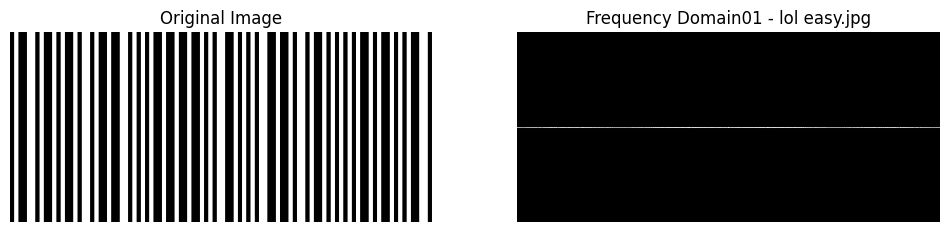

11110000111111110000000011110000111111110000111100001111111100001111000000001111000011111111000011111111000000001111000011110000111100001111111100001111111100001111111100001111111100001111000011110000000011111111000011110000111100001111000000001111111100001111111100001111000000001111000011111111000011110000111100001111000011110000111111110000111100001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']


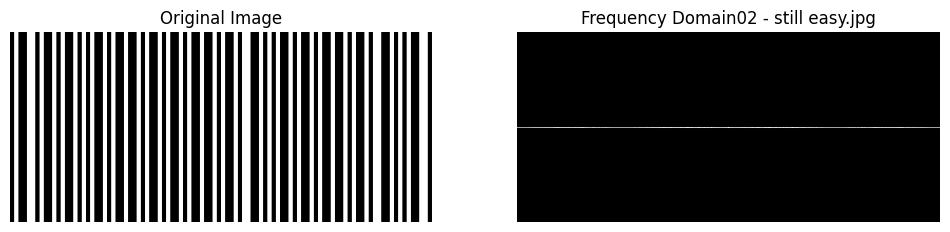

11110000111111110000000011110000111111110000111100001111111100001111000011110000111111110000111100001111111100001111111100001111000011111111000011110000111111110000111100001111111100001111111100001111000011111111000011110000000011111111000011110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111000000001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start']


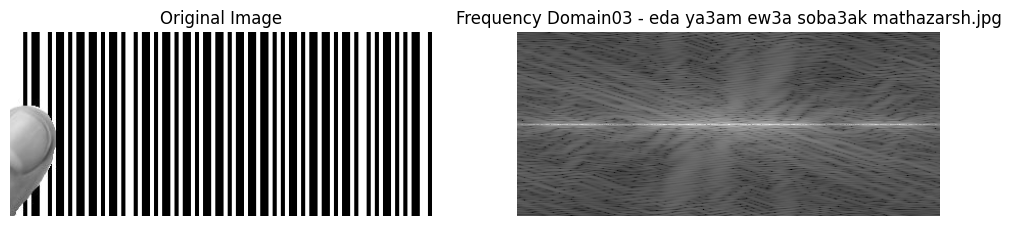

11110000111111110000000011110000111111110000111100001111111100001111111100001111000011111111000011110000000011110000111111110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111111100001111111100001111000011110000111111110000111100001111111100001111111100001111000011111111000011110000000011110000111100001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '1', '1', '2', '-', '1', '1', '5', '-', '5', '8', '-', 'Stop/Start']


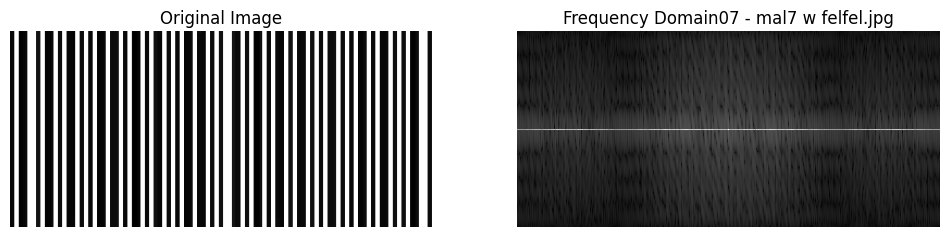

11110000111111110000000011110000111111110000111100001111111100001111000011110000111111110000111111110000111100001111111100001111000011111111000011110000111100001111111100001111111100001111000011110000000011111111000011110000111111110000111100001111111100001111000011111111000011110000111100001111111100001111000011110000111111110000111100001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '1', '0', '1', '-', '4', '7', '-', '1', '0', '0', '-', 'Stop/Start']


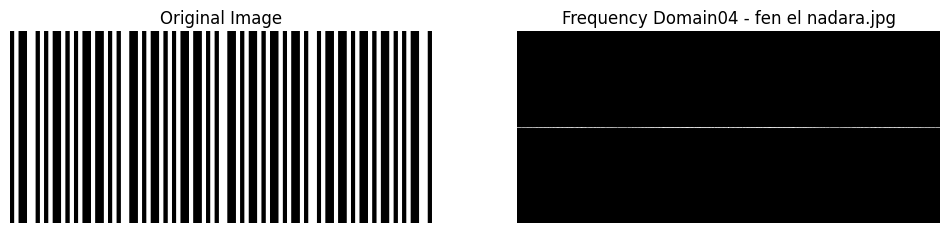

1111000011111111000000001111000011110000111111110000111100001111000011111111000011111111000011110000111100000000111111110000111100001111111100001111000011110000111111110000111111110000111100001111000000001111111100001111000011111111000011110000111111110000111100001111111100001111000000001111000011111111000011111111000011110000111111110000111100001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '-', '4', '7', '-', '4', '7', '-', '1', '2', '1', '-', 'Stop/Start']


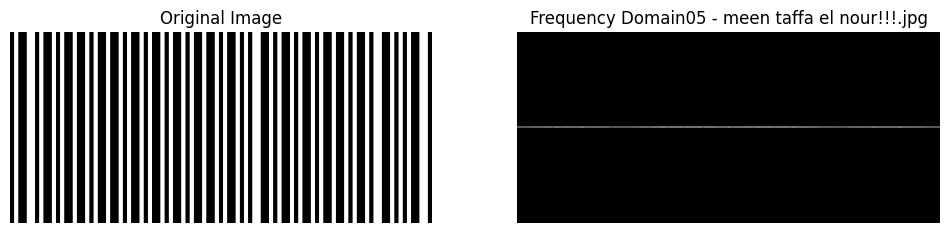

111100001111111100000000111100001111111100001111000011111111000011111111000011110000111111110000111111110000111100001111111100001111000011111111000011110000111111110000111100001111111100001111111100001111000011111111000011110000111100000000111111110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111000000001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '1', '1', '1', '-', '1', '1', '7', '-', '1', '1', '6', 'Stop/Start']


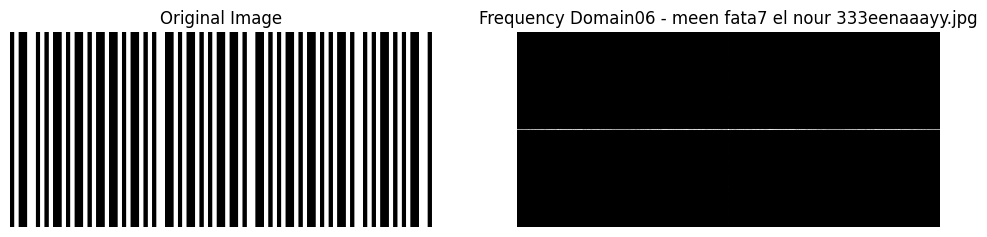

111100001111111100000000111100001111000011111111000011110000111111110000111100001111111100001111111100001111000011111111000011110000111100000000111111110000111100001111111100001111000011110000111111110000111111110000111100000000111111110000111100001111000011111111000011110000111111110000111100001111000011111111000011110000000011110000111100001111111100001111000011110000111111110000000011110
Decoded barcode value: ['Stop/Start', '-', '1', '1', '7', '-', '4', '6', '-', '9', '8', '-', 'Stop/Start']


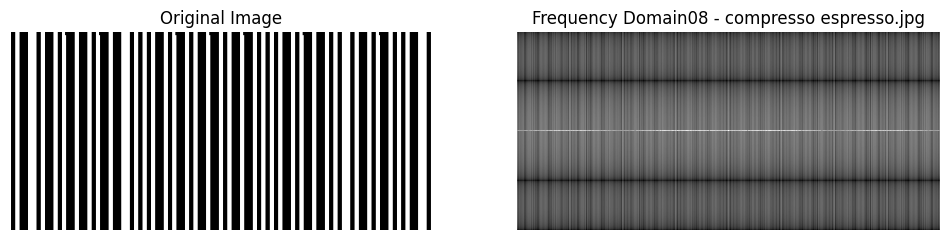

11110000111111110000000011110000111111110000111100001111111100001111111100001111000011111111000011111111000000001111000011110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111111100001111000011110000111100001111111100001111000011111111000011111111000011110000111100000000111100001111111100001111000011111111000011110000111100001111111100000000111100
Decoded barcode value: ['Stop/Start', '1', '1', '3', '-', '1', '1', '9', '-', '5', '2', '-', 'Stop/Start']


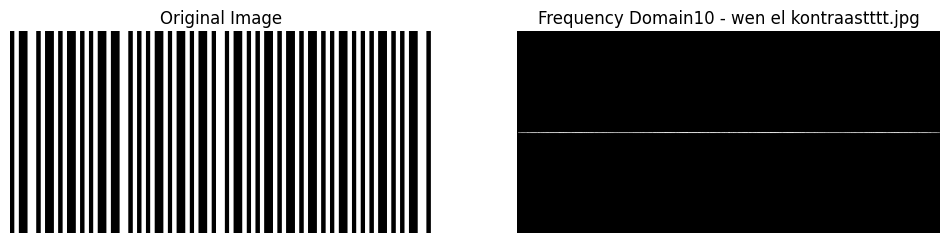

11110000111111110000000011110000111111110000111100001111111100001111000011110000111111110000111111110000000011110000111100001111000011111111000011110000111111110000111100001111111100001111000000001111000011111111000011110000111100001111111100001111000011111111000011110000111111110000111100001111000011111111000011110000111100001111000011111111000011110000111100001111111100000000111100
Decoded barcode value: ['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start']


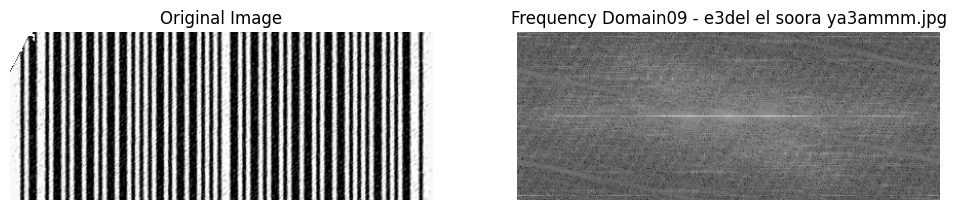

111100001111111100000000111100001111111100001111000011111111000011111111000011110000111111110000111111110000111100001111000011110000111111110000111100001111111100001111111100001111000011110000111100000000111111110000111100001111111100001111000011111111000011110000111111110000111111110000111100001111111100001111111100001111000011110000111100001111111100001111000011110000111111110000000011110000000000
Decoded barcode value: ['Stop/Start', '1', '1', '9', '-', '5', '7', '-', '1', '1', '9', '-', 'Stop/Start']


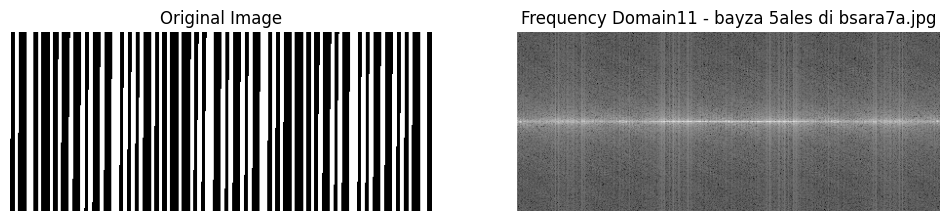

1111000011111111000000011111000111111111000111110000111111100000111111100000111000001111111000001111111000000000111000001110000011100000111111110000111100011111000111111111000111111111000011100000111000000000111111100000111000001111111000001110000011111110000000001111000011110000111111110001111111110001111100011110000011111110000011100000111111100000000011100000111000001111111000001111111000001110000011110000111111110000000111110
Decoded barcode value: ['Stop/Start', '1', '1', '3', '-', '4', '7', '-', '3', '5', '-', '3', '5', 'Stop/Start']


In [ ]:


        



ready_for_decoding = []
not_ready = []

def phase0():  # if only cropping is needed to fix
    for pic in picture_names:
        image = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
        org_image = image.copy()
        try:
            image = crop_image_contour_sorry_kiwi(image)
        except:
            print("can't be cropped")
        if decode_barcode(image):
            ready_for_decoding.append((image, pic))  # Store image with its name
        else:
            not_ready.append((org_image, pic))  # Store image with its name




def phase2():  # fix lighting problems
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image, pic in not_ready[:]:
        org_image = image.copy()
        hist_counts, bin_edges, total_pixels = compute_histogram(image)
        if (detect_bright(hist_counts, bin_edges, total_pixels) or
            detect_dark(hist_counts, bin_edges, total_pixels) or
            detect_contrast(hist_counts, bin_edges, total_pixels) or detectBlur(image)):
            image = threshold_image(image, find_threshold_value(image), 255)
            cropped_img = crop_image_contour_sorry_kiwi(image)

        if decode_barcode(cropped_img):
            not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
            ready_for_decoding.append((cropped_img, pic))  # Store image with its name
        elif(not detect_periodic_noise_lines_with_opencv(org_image)):
             not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
             not_ready.append((image, pic))

    

             


def phase1():  # Searching for salt and pepper
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image, pic in not_ready[:]:
        org_image = image.copy()
        if detect_salt_pepper_noise(image):
            image = perform_closing(image)
            cropped_image = crop_image_contour_sorry_kiwi(image)

            print('\n')
            print('\n')
            print('\n')
            print('\n')
            print('\n')
            print('slatsdas')
            print('\n')
            print('\n')
            print('\n')
            print('\n')
            print('\n')


            if decode_barcode(cropped_image):
                not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
                ready_for_decoding.append((cropped_image, pic))  # Store image with its name
            else:
                not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
                not_ready.append((image, pic))  # Store image with its name

def phase3():  # angles
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image, pic in not_ready[:]:  # Iterate over a copy of the list to avoid modifying it during iteration
        org_image = image.copy()
        if find_angle(image) != 0:
            angle = find_angle(image)
            image = rotate_img(image, angle)
            image = fill_corners(image)
            cropped_img = crop_image_contour_sorry_kiwi(image)
        if decode_barcode(cropped_img):
            not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
            ready_for_decoding.append((cropped_img, pic))  # Store image with its name
        else:
            not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
            not_ready.append((image, pic))  # Store image with its name


def phase4():  # angles
    global not_ready  # Tell Python to use the global 'not_ready' list
    for image, pic in not_ready[:]:  # Iterate over a copy of the list to avoid modifying it during iteration
        org_image = image.copy()
        if detect_periodic_noise_lines_with_opencv(image,offset=2):
            image=remove_periodic_noise(image)
            image=crop_image_contour_sorry_kiwi(image)
            # image= cv2.medianBlur(image, 3)

            image=threshold_image(image,find_threshold_value(image),255)
            image= perform_opening(image)
            if decode_barcode(image):
                not_ready = [(img, name) for img, name in not_ready if name != pic]  # Remove org_image
                ready_for_decoding.append((image, pic))  # Store image with its nam
            

phase0()

phase1()
phase2()

phase3()
phase4()


for image,pic in not_ready:
    print(pic)


print('ready')
for image, pic in ready_for_decoding:
    show_frequency_domain(image,pic)
    decode_barcode(image)



      
 



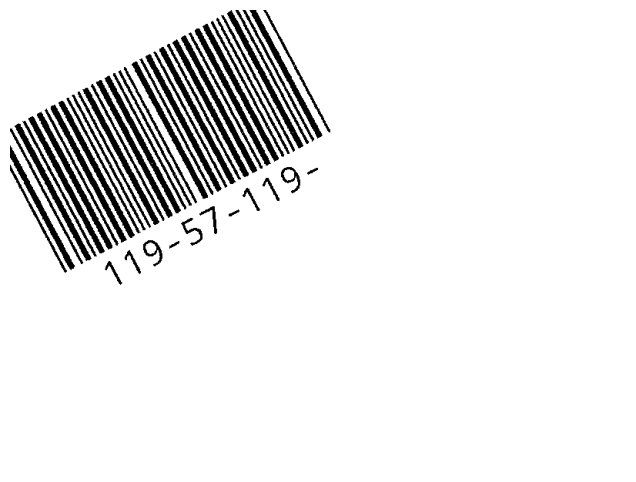

(False, 0)
(True, 2)


In [541]:
image=cv2.imread("09 - e3del el soora ya3ammm.jpg",cv2.IMREAD_GRAYSCALE)

threshold=find_threshold_value(image)

_,t_image=cv2.threshold(image,threshold,255,cv2.THRESH_BINARY)

display_image(t_image)

print(detect_periodic_noise_lines_with_opencv(rotate_img(t_image,find_angle(t_image)),offset=2))


# print(detectBlur(t_image))

image2=cv2.imread("11 - bayza 5ales di bsara7a.jpg",cv2.IMREAD_GRAYSCALE)



print(detect_periodic_noise_lines_with_opencv(rotate_img(image2,find_angle(image2)),offset=2))

In [440]:
for pic in ready_for_decoding:
    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    your_cropped_image=pic
    # Get the average of each column in your image
    mean = your_cropped_image.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    # Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

    wide_bar_size = narrow_bar_size * 2

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):

        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1

        current_digit_widths += NARROW if count == narrow_bar_size else WIDE

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

   
    print(digits)


['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']
['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start']
['Stop/Start', '-', '4', '7', '-', '4', '7', '-', '1', '2', '1', '-', 'Stop/Start']
['Stop/Start', '1', '1', '1', '-', '1', '1', '7', '-', '1', '1', '6', 'Stop/Start']
['Stop/Start', '-', '1', '1', '7', '-', '4', '6', '-', '9', '8', '-', 'Stop/Start']
['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start']
['Stop/Start', '1', '0', '1', '-', '4', '7', '-', '1', '0', '0', '-', 'Stop/Start']
['Stop/Start', '1', '1', '2', '-', '1', '1', '5', '-', '5', '8', '-', 'Stop/Start']
[]


third pic

1111000001111111100000000111100011111111100001111000011111110000011111110000011100000011111100000011111100000000001127000001110000011100000111111100000111100001111000011111111000011111110000011100000111000000000111111100000111000001111111000001110000011111110000000001110000011110000111111110000111111110000111000001110000011111110000011100000111111100000000001100000111000000111111000001111111000001110000011100000111111110000000111110


In [379]:
# 0 means narrow, 1 means wide
NARROW = "0"
WIDE = "1"
code11_widths = {
    "00110": "Stop/Start",
    "10001": "1",
    "01001": "2",
    "11000": "3",
    "00101": "4",
    "10100": "5",
    "01100": "6",
    "00011": "7",
    "10010": "8",
    "10000": "9",
    "00001": "0",
    "00100": "-",
}

your_cropped_image=final_image
# Get the average of each column in your image
mean = your_cropped_image.mean(axis=0)

# Set it to black or white based on its value
mean[mean <= 127] = 1
mean[mean > 128] = 0

# Convert to string of pixels in order to loop over it
pixels = ''.join(mean.astype(np.uint8).astype(str))

# Need to figure out how many pixels represent a narrow bar
narrow_bar_size = 0
for pixel in pixels:
    if pixel == "1":
        narrow_bar_size += 1
    else:
        break

wide_bar_size = narrow_bar_size * 2

digits = []
pixel_index = 0
current_digit_widths = ""
skip_next = False

while pixel_index < len(pixels):

    if skip_next:
        pixel_index += narrow_bar_size
        skip_next = False
        continue

    count = 1
    try:
        while pixels[pixel_index] == pixels[pixel_index + 1]:
            count += 1
            pixel_index += 1
    except:
        pass
    pixel_index += 1

    current_digit_widths += NARROW if count == narrow_bar_size else WIDE

    if current_digit_widths in code11_widths:
        digits.append(code11_widths[current_digit_widths])
        current_digit_widths = ""
        skip_next = True  # Next iteration will be a separator, so skip it

print(digits)

[]
